In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

2024-04-04 09:47:57.041322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 09:47:57.636002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def read_data(pathC,pathE):
    df  = pd.DataFrame(columns =['x1','y1','z1','x2','y2','z2','x3','y3','z3'])
    c = []

    with open(pathC) as f:
        for line in f:
            if(line[0]=='H' or line[0]=='O'):
                cords=(line.split())
                c.append(float(cords[1]))
                c.append(float(cords[2]))
                c.append(float(cords[3]))
                
                if(len(c)==9):              
                    df.loc[len(df.index)] = c
                    c=[]

    with open(pathE) as f:
        for line in f:
            c.append(float(line.strip()))
    df.insert(9,"energy",c)

    return df


def get_dist(x1,y1,z1,x2,y2,z2):
    return np.sqrt( (x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2 )

def normalize_data(df):
    return df.iloc[:,0:].apply(lambda x: (x-x.mean())/(x.max() - x.min()), axis=0)

In [54]:
h2o_unrotated = read_data("./data/H2O_unrotated.xyz","./data/H2O_unrotated.ener")
h2o_test = read_data("./data/H2O_test.xyz","./data/H2O_test.ener")
h2o_rotated = read_data("./data/H2O_rotated.xyz","./data/H2O_rotated.ener")

In [55]:
h2o_rotated.describe()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,energy
count,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,0.254273,0.140451,0.120025,0.214996,0.280351,0.225502,0.078098,0.125235,0.202120,-76.376522
std,5.638545,5.671937,5.668902,5.650367,5.652361,5.651572,5.718155,5.692253,5.661974,0.003653
min,-10.693631,-10.506496,-10.393386,-10.060697,-10.125863,-10.235891,-10.638510,-10.671854,-10.317953,-76.380752
25%,-4.414594,-4.437316,-4.600717,-4.426472,-4.423391,-4.357949,-4.647912,-4.656413,-4.539722,-76.379181
50%,0.340002,0.212041,0.198453,0.318543,0.337848,0.337980,0.199021,0.089593,0.251248,-76.377624
75%,5.193472,4.959406,4.986227,5.172096,5.242135,5.166992,5.010558,5.023500,5.137699,-76.375009
max,10.527868,10.598302,10.375763,10.185401,10.260749,10.293548,10.604322,10.707676,10.238004,-76.354093


In [56]:
h2o_distances = pd.DataFrame(columns=['OH1','OH2','HH'])

for molecule in h2o_unrotated.iterrows():
    atoms = molecule[1]
    oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
    oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
    hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
    h2o_distances.loc[len(h2o_distances.index)] = [oh1,oh2,hh]

h2o_distances.insert(3,"energy",h2o_unrotated.energy)

In [57]:
h2o_distances_test = pd.DataFrame(columns=['OH1','OH2','HH'])

for molecule in h2o_test.iterrows():
    atoms = molecule[1]
    oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
    oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
    hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
    h2o_distances_test.loc[len(h2o_distances_test.index)] = [oh1,oh2,hh]

h2o_distances_test.insert(3,"energy",h2o_test.energy)

In [59]:
h2o_rot_distances = pd.DataFrame(columns=['OH1','OH2','HH'])

for molecule in h2o_rotated.iterrows():
    atoms = molecule[1]
    oh1 = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x2,atoms.y2,atoms.z2)
    oh2 = get_dist(atoms.x3,atoms.y3,atoms.z3,atoms.x2,atoms.y2,atoms.z2)
    hh  = get_dist(atoms.x1,atoms.y1,atoms.z1,atoms.x3,atoms.y3,atoms.z3)
    h2o_rot_distances.loc[len(h2o_rot_distances.index)] = [oh1,oh2,hh]

h2o_rot_distances.insert(3,"energy",h2o_rotated.energy)

In [60]:
h2o_rot_distances

,OH1,OH2,HH,energy
0,1.010110,0.921727,1.575566,-76.376448
1,0.879404,1.013385,1.541574,-76.369670
2,0.988207,0.916030,1.519479,-76.377519
3,0.907936,0.908788,1.509746,-76.372594
4,0.910070,0.997601,1.486468,-76.376294
...,...,...,...,...
1745,0.967991,0.879471,1.545238,-76.370585
1746,0.962867,0.943265,1.593811,-76.378377
1747,0.939703,0.938571,1.525009,-76.378841
1748,1.002135,0.900750,1.468643,-76.374492


In [64]:
inp_data = normalize_data(h2o_distances)
tst_data = normalize_data(h2o_distances_test)
rot_data = normalize_data(h2o_rot_distances)

inp_data = pd.concat([inp_data,rot_data])

In [66]:
inp_data.describe()

,OH1,OH2,HH,energy
count,3.500000e+03,3.500000e+03,3.500000e+03,3.500000e+03
mean,-2.055499e-17,-4.061513e-16,3.273572e-16,2.994325e-13
std,1.758674e-01,1.985990e-01,1.902641e-01,1.370150e-01
min,-5.106211e-01,-4.997594e-01,-4.780469e-01,-1.586852e-01
25%,-1.239700e-01,-1.441765e-01,-1.353454e-01,-9.976152e-02
50%,-3.481928e-03,1.423257e-03,-5.599890e-03,-4.133408e-02
75%,1.260983e-01,1.409966e-01,1.355070e-01,5.677629e-02
max,4.893789e-01,5.002406e-01,5.219531e-01,8.413148e-01


In [67]:
keras.backend.clear_session()

In [68]:
model = keras.Sequential()

model.add( keras.layers.Input(shape=(3,)))
# model.add( keras.layers.Input(shape=(9,)))

model.add( keras.layers.Dense(
    32,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    16,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    8,
    activation='sigmoid',
    kernel_regularizer=keras.regularizers.l2(1e-6),
    bias_regularizer=keras.regularizers.l2(1e-6)
))
model.add( keras.layers.Dense(
    1,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_bias=False
))

model.compile(optimizer=keras.optimizers.Adam(0.001),loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800 (3.12 KB)

 Trainable params: 800 (3.12 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# train, test = train_test_split(h2o_unrotated, test_size=0.2,random_state=8123)
train, val = train_test_split(inp_data, test_size=0.2,random_state=8123)
history = model.fit(train.iloc[:,0:-1],train.iloc[:,-1:],validation_data=(val.iloc[:,0:-1],val.iloc[:,-1:]),epochs=500)

Epoch 1/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3281 - val_loss: 0.0180
Epoch 2/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0174
Epoch 3/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0183 - val_loss: 0.0171
Epoch 4/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0177 - val_loss: 0.0168
Epoch 5/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - val_loss: 0.0166
Epoch 6/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0182 - val_loss: 0.0163
Epoch 7/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 8/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 - val_loss: 0.0158
Epoch 9/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 10/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 11/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0163 - val_loss: 0.0149
Epoch 12/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

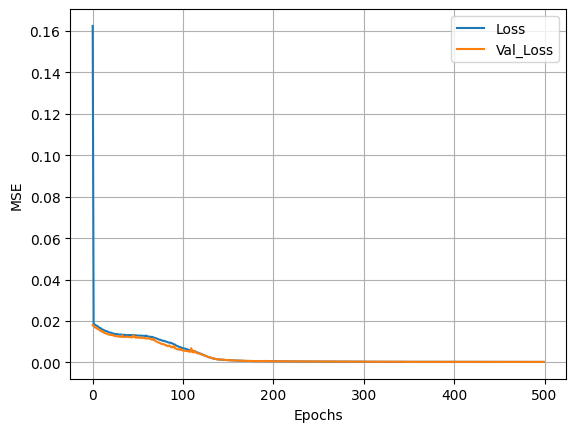

In [70]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# test_energies = h2o_test.iloc[:,-1:]
# test_cords = h2o_test.iloc[:,0:-1]

test_energies = tst_data.iloc[:,-1:]
test_cords = tst_data.iloc[:,0:-1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


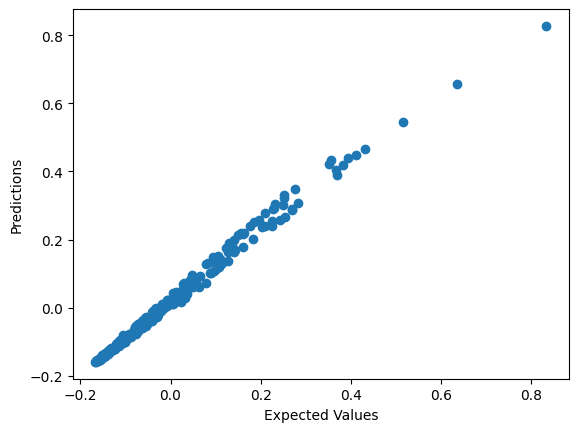

0.026303056592040394


In [72]:
predictions = model.predict(test_cords)
rmse = np.sqrt(np.mean((predictions-test_energies)**2))

plt.scatter(test_energies, predictions)
plt.xlabel('Expected Values')
plt.ylabel('Predictions')
plt.show()

print(rmse)